
Bad key "text.kerning_factor" on line 4 in
C:\Users\nerpa\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


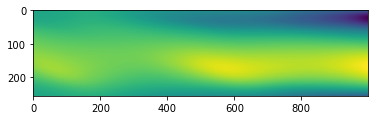

In [1]:
import numpy as np

from weight import *
from utils import save, load
from library import *
from process_library_terms import *
import matplotlib.pyplot as plt

import h5py
#with h5py.File('NSE2D/uvp-0.001.mat', 'r') as mat:
with h5py.File('NSE2D/uvp2-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/tgv-0.001.mat', 'r') as mat:
    P = np.array(mat['P'])
    U = np.array(mat['U'])
    V = np.array(mat['V'])
    
#import netCDF4 as nc
#fn = '/path/to/file.nc4'
#ds = nc.Dataset(fn)

# for some reason, we need to fix the order of the axes
P = np.transpose(P, (1, 2, 0))
U = np.transpose(U, (1, 2, 0))
V = np.transpose(V, (1, 2, 0))

Lx = 4; Ly = 4; Lt = 1;
#Nx = 512; Ny = Nx; Nt = 1000; # normal resolution
Nx = 256; Ny = Nx; Nt = 1000; # half resolution
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

# don't use MATLAB data
#x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 0.2, dt)
#xg, yg = np.meshgrid(x, y)
#U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
#V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
#P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, 128, :])

0.027839316314777207

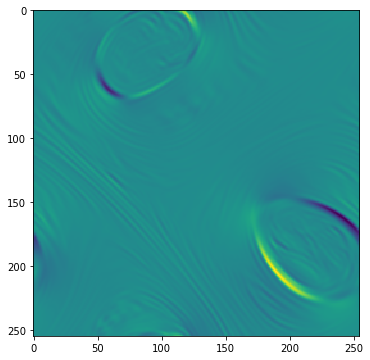

In [2]:
fig, ax= plt.subplots(figsize=(6,6))
dU = np.diff(U[:, :, -1], axis=0)
dV = np.diff(V[:, :, -1], axis=1)
ax.imshow(dU[:,1:]+dV[1:,:])
np.max(dU[:,1:]+dV[1:,:])

In [21]:
uobs = Observable('u', 1)
pobs = Observable('p', 0)

u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

### define all parameters and "make library"
terms = generate_terms_to(5, observables=[uobs, pobs], max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(U.shape)
m = 12
qmax = 1
nweights = qmax**4
ndomains = 250
wx = 64
wt = 50
pad = 0


In [22]:
#%%prun

# fix random seed
np.random.seed(1)

data_dict = {'p': P, 'u': u}

dxs = [dx, dy, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dx, (wt-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        for q3 in range(qmax):
            for q4 in range(qmax):
                weights.append(Weight([m]*3, [q1, q2, q3], [0]*3, dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
domains = make_domains([wx, wx, wt], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs, debug=False)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs, debug=False)#, by_parts=False)

In [23]:
#from sparse_reg import *
from ipynb.fs.full.sparse_reg import *
opts = dict()
#opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
opts['threshold'] = "'threshold'"
opts['n_terms'] = len(terms0)
opts['gamma'] = 1.5
opts['verbose'] = True
opts['delta'] = 1e-8 #apparently this reaches machine precision as the relative error
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, opts=opts, char_sizes=char_sizes0)

V: [[-4.63864073e-19 -3.54933205e-15 -6.12101169e-14 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.11022302e-16 -7.01861421e-13  6.02175428e-13 ... -1.12287881e-07
  -2.35635266e-09 -4.33841954e-01]
 [-3.86275213e-14  3.83184950e-09  9.76085412e-09 ... -2.07373745e-06
  -9.92910852e-08  2.16355288e-04]
 ...
 [ 1.47028196e-16  8.09261270e-13 -2.36604723e-12 ... -1.37109266e-08
  -9.06128311e-10  6.86912368e-02]
 [-1.99129704e-16 -1.29164346e-12  3.73297799e-12 ... -1.28081739e-08
  -4.31899195e-10  2.78680671e-02]
 [ 1.46924655e-11  1.15338718e-07 -4.93677902e-07 ...  2.82189861e-09
  -1.45101657e-10 -1.98914964e-02]]
scores: [55.09756062 46.69614153 45.64558388 45.61404371 44.26022294 43.10206379
 42.01082748 40.70230446 40.55420579 39.23946318 37.97095701 37.72443648
 36.8556679  36.25996063 36.06635142 35.87204366 35.65783235 35.46811316
 35.24833667 35.01005376 34.75860849 34.70266277 34.48807792 34.3275552
 33.40441704 33.18308752 32.83795883 32.36156631 32.24599194 3

In [24]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

[Term 27] 1.0 * dj u_j
Model residual: 1.5688935232936766e-14
One-term model residual: 1.5688935232936766e-14
Best term (#27): dj u_j


In [25]:
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts=opts, char_sizes=char_sizes1)

V: [[ 5.98808475e-16 -2.99500883e-14  4.14185850e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.48708881e-11  1.40715481e-09 -8.25262338e-08 ...  7.07223029e-14
   9.55901962e-14 -5.62945197e-03]
 [ 6.27648541e-13 -1.35924705e-09 -3.69262361e-09 ...  8.14797654e-11
   1.00629195e-09  1.31798012e-03]
 ...
 [-8.27017180e-11  3.11296168e-08 -1.70804065e-06 ...  1.05116789e-18
   4.33680869e-19  2.71018856e-07]
 [ 3.01465839e-09 -2.48046799e-08  1.11645985e-05 ...  5.79370536e-19
   1.76182853e-19 -3.94593196e-08]
 [ 6.37553842e-10  5.11507649e-08  8.93843878e-06 ...  2.45639555e-20
  -3.13402190e-19 -1.34002600e-08]]
scores: [54.88057609 49.48253396 45.97456566 44.69404172 44.01801671 43.52644622
 42.23460139 41.71974794 41.38257914 40.43091616 40.03432988 39.79016772
 39.17311718 38.90551399 38.72607486 38.09359335 38.04082087 37.47280579
 36.75246308 36.37505475 35.72722182 35.51533834 35.465544   34.90549088
 34.88578133 34.62824949 34.56308101 34.32699684 34.23124149 

In [26]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 41] 2.294179593093145e-18 * u_i * dt dj^2 p
[Term 46] -1.06715330263772e-12 * di dj u_j * dt p
[Term 129] -0.9999999999976129 * dj u_j * di u_k * u_k
[Term 130] 0.9999999999949455 * dj u_k * di u_j * u_k
[Term 132] 1.0 * dj u_j * dk u_i * u_k
[Term 134] -0.9999999999949455 * dj u_k * dk u_i * u_j
Model residual: 6.489748810149673e-15
One-term model residual: 1.454843881558218e-09
Best term: di dj u_j


In [27]:
avoid = []
avoid.append(Xi)
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts=opts, char_sizes=char_sizes1, avoid=avoid)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

V: [[ 5.98808475e-16 -2.99500883e-14  4.14185850e-12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-8.48708881e-11  1.40716014e-09 -8.25270858e-08 ... -3.65663524e-14
   4.30601432e-14  5.64768745e-03]
 [ 6.27648541e-13 -1.35924660e-09 -3.69262783e-09 ... -8.99450805e-10
  -1.32844545e-09 -1.31478224e-03]
 ...
 [-8.27017180e-11  3.11296168e-08 -1.70804065e-06 ...  4.77197187e-19
   5.92923063e-19 -2.71015734e-07]
 [ 3.01465839e-09 -2.48046799e-08  1.11645985e-05 ...  1.24683250e-18
   8.13151629e-19  3.96914956e-08]
 [ 6.37553842e-10  5.11507649e-08  8.93843878e-06 ... -1.32560656e-19
  -4.77726582e-19  1.33474450e-08]]
scores: [54.88057609 49.48253396 45.97456566 44.69404172 44.01801671 43.52644622
 42.23460139 41.71974794 41.38257914 40.43091616 40.03432988 39.79016772
 39.17311718 38.90551399 38.72607486 38.09359335 38.04082087 37.47280579
 36.75246308 36.37505475 35.72722182 35.51533834 35.465544   34.90549088
 34.88578133 34.62824949 34.56308101 34.32699684 34.23124149 

In [28]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)
for term, size in zip(terms1, char_sizes1):
    print(term, size)

1 1
p 11.909507841829365
dj^2 p 0.0020416148869192457
dj^2 dk^2 p 4.98441134501769e-07
dt p 0.00836245457682123
dt dj^2 p 2.0416148869192455e-06
dt^2 p 8.36245457682123e-06
dt^2 dj^2 p 2.0416148869192456e-09
dt^3 p 8.362454576821231e-09
dt^4 p 8.362454576821232e-12
p * p 141.83637703459513
dj p * dj p 0.017072911755224206
dj^2 p * p 0.024314628505760327
dt p * p 0.0995927183595943
dt p * dj^2 p 1.7072911755224202e-05
dt dj p * dj p 1.7072911755224202e-05
dt dj^2 p * p 2.4314628505760326e-05
dt p * dt p 6.993064654939833e-05
dt^2 p * p 9.959271835959431e-05
dt^2 p * dt p 6.993064654939835e-08
dt^3 p * p 9.959271835959432e-08
p * p * p 1689.2014445501773
dj p * dj p * p 0.20332997643170342
dj^2 p * p * p 0.28957525886052043
dt p * p * p 1.1861002602926916
dt p * dt p * p 0.0008328395834642571
dt^2 p * p * p 0.0011861002602926917
dj u_j 0.036687726462512296
dj^2 dk u_k 8.956964468386791e-06
dt dj u_j 3.6687726462512294e-05
dt dj^2 dk u_k 8.95696446838679e-09
dt^2 dj u_j 3.668772646251229e